In [117]:
from collections import defaultdict
import json
import pathlib
import re
import pandas as pd
import torch

experiments = pd.DataFrame(columns=['degree', 'dataset', 'frame'])


def or_raise[T](v: T | None) -> T:
    if v is None:
        raise ValueError(v)
    return v


def get_experiments():
    for degree in pathlib.Path('/home/aq85800/NewVolume/gsplat/sh-degree').iterdir():
        for dataset in degree.iterdir():
            for frame in dataset.iterdir():
                indep = {
                    'degree': int(degree.stem),
                    'dataset': dataset.stem,
                    'frame': int(or_raise(re.search(r'\d+$', frame.stem))[0]),
                }
                try:
                    # get most recent stat file
                    percams = [
                        sorted((frame/'stats').glob(glob),
                               key=lambda p: p.stat().st_mtime,
                               reverse=True)[0]
                        for glob in ['all_percam*.pt']
                    ]
                except IndexError:
                    continue

                with (frame/'cfg.yml').open() as cfg:
                    while line := cfg.readline():
                        if match := re.match(r'test_every: (?P<test_every>\d+)', line):
                            test_every = int(match['test_every'])

                for percam in [torch.load(f, weights_only=False) for f in percams]:
                    for metric, values in percam.items():
                        for cam, value in enumerate(values):
                            yield {
                                **indep,
                                'cam': cam,
                                'metric': f'{metric}_{"test" if cam % test_every == 0 else "train"}',
                                'value': float(value.item()),
                            }


experiments = pd.DataFrame.from_records(get_experiments())
experiments.to_csv('sh-degree_percam_metrics.csv', index=False)

/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/aq85800/anaconda3/envs/ploten

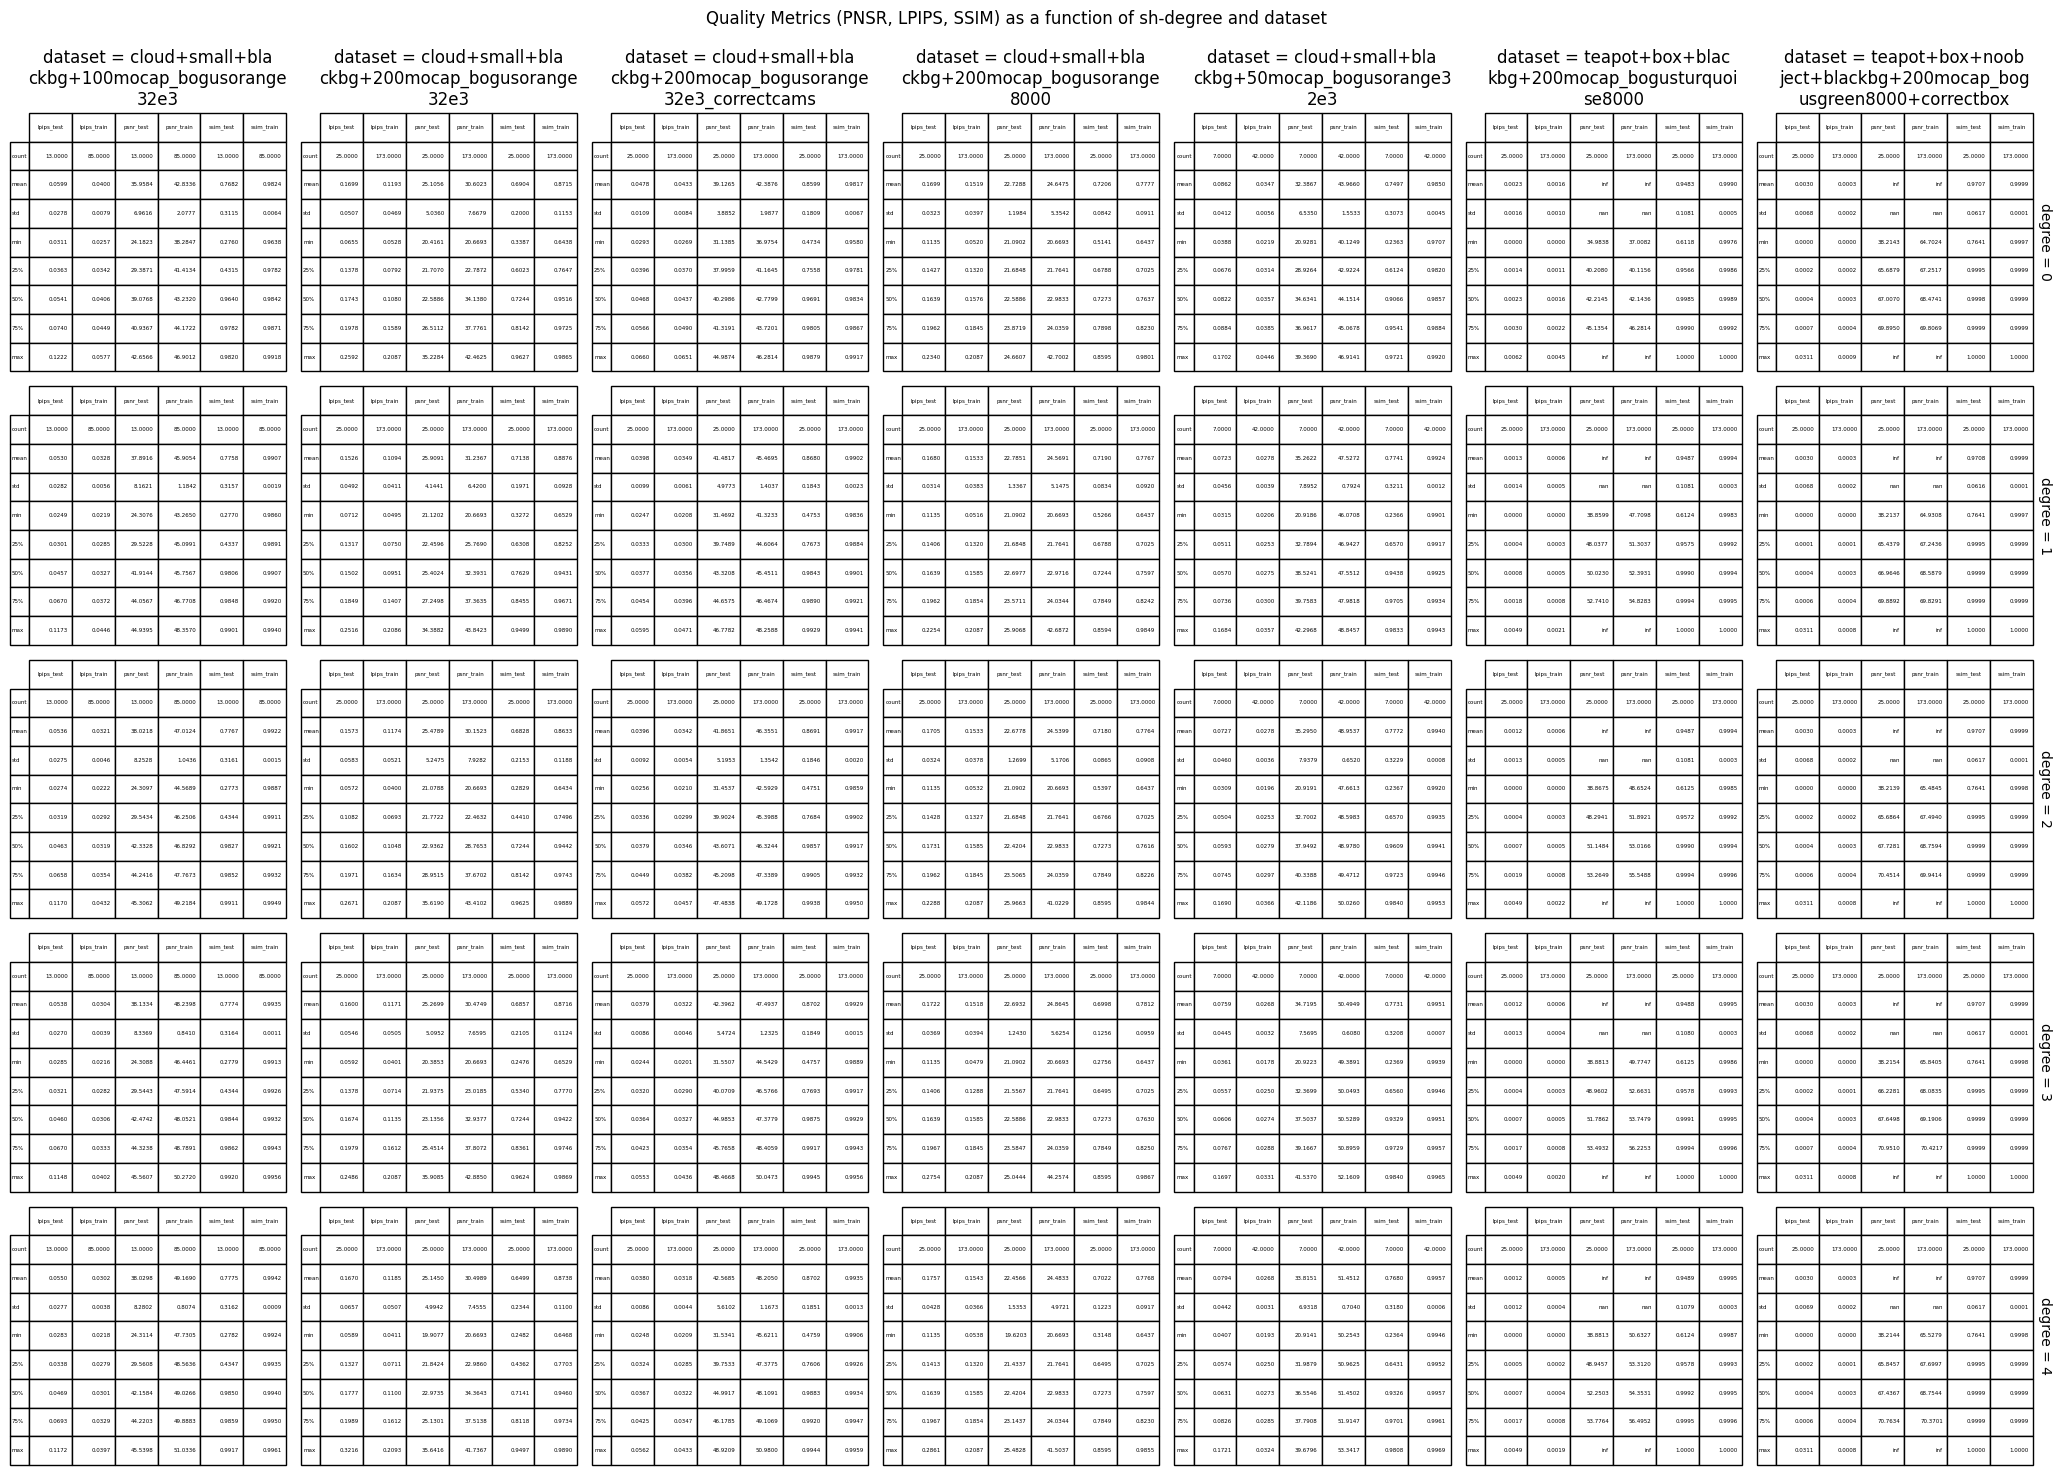

In [118]:
from matplotlib.transforms import Bbox
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import textwrap

grid = sb.FacetGrid(experiments, row='degree', col='dataset',
                    margin_titles=True, despine=False, )
grid.figure.suptitle(
    'Quality Metrics (PNSR, LPIPS, SSIM) as a function of sh-degree and dataset\n')

ax: Axes
for (degree, dataset), ax in grid.axes_dict.items():
    subf = experiments.query('degree==@degree and dataset==@dataset')
    subf = subf.pivot(index=['degree', 'dataset', 'frame',
                      'cam'], columns='metric', values='value')
    ax.table(subf.describe().map(lambda x: f"{x:.04f}"), bbox=Bbox(((0, 0), (1, 1))))
    ax.set_title(textwrap.fill(ax.title.get_text(), 25))
    ax.axis('off')
    ax.axis('tight')

grid.tight_layout()
grid.savefig('sh-degree_describe.svg')

In [119]:
def get_renders():
    for degree in pathlib.Path('/home/aq85800/NewVolume/gsplat/sh-degree').iterdir():
        for dataset in degree.iterdir():
            for frame in dataset.iterdir():
                try:
                    for path in frame.glob('renders/all*_step29999_0000.png'):
                        render = plt.imread(path)
                        gt = render[:,:render.shape[1]//2]
                        render = render[:,render.shape[1]//2:]
                        render = np.vstack((gt, render))
                        break
                except FileNotFoundError:
                    render = None
                yield {
                    'degree': int(degree.stem),
                    'dataset': dataset.stem,
                    'frame': int(or_raise(re.search(r'\d+$', frame.stem))[0]),
                    'render': render
                }


experiments = pd.DataFrame.from_records(get_renders())

Index(['degree', 'dataset', 'frame', 'render'], dtype='object')


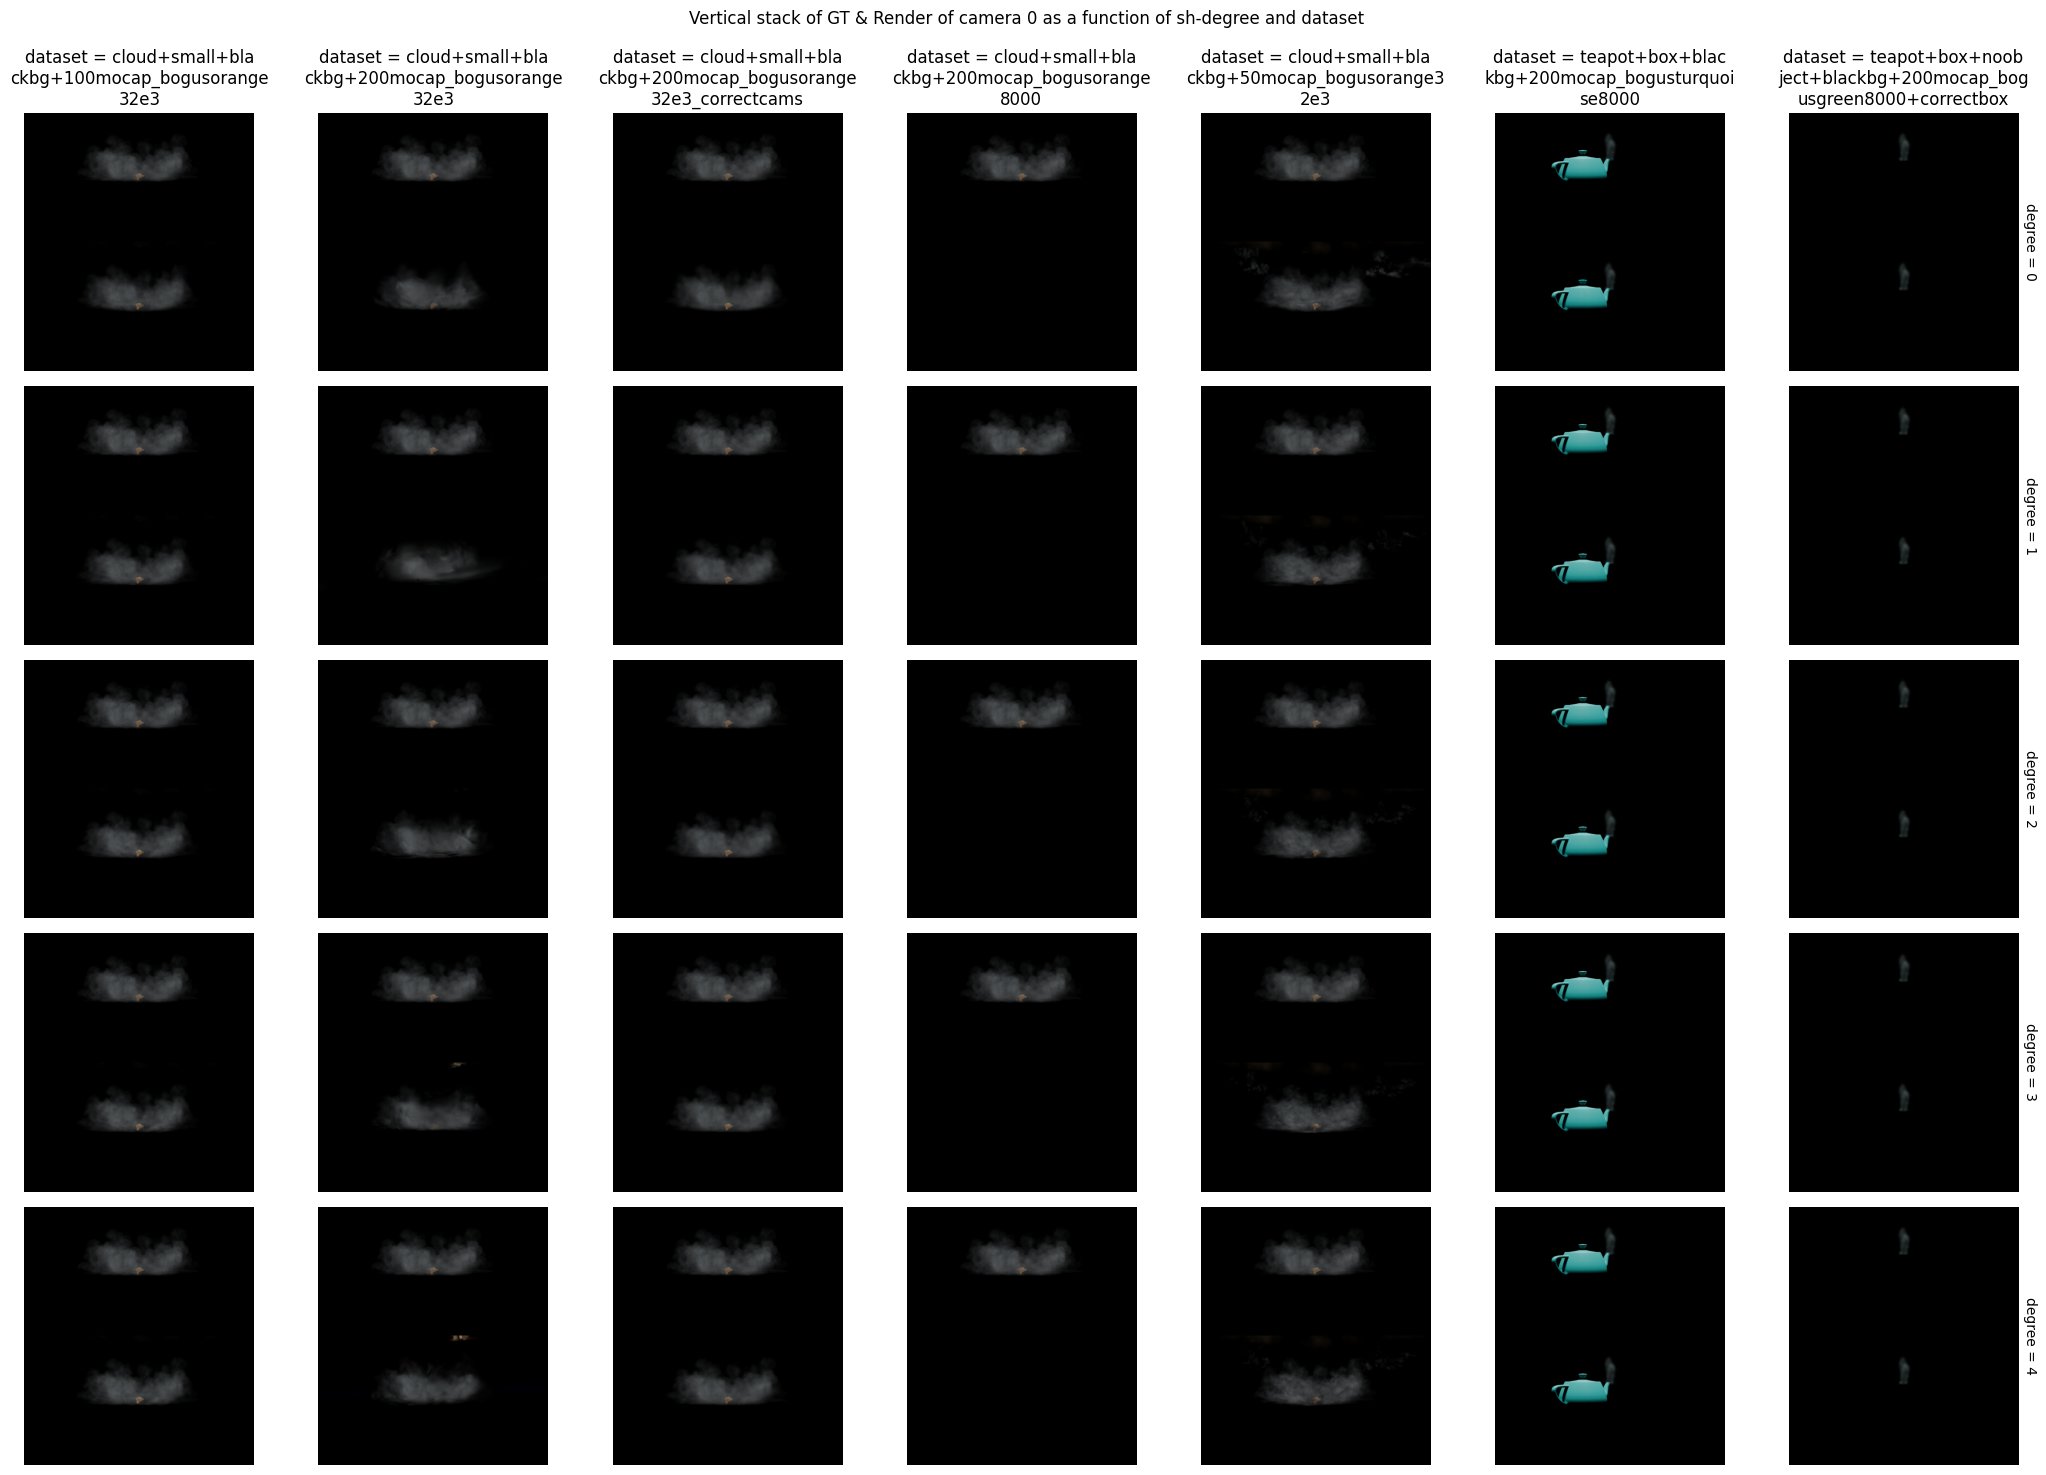

In [120]:
print(experiments.columns)

grid = sb.FacetGrid(experiments, row='degree', col='dataset',
                    margin_titles=True, despine=False, )
grid.figure.suptitle(
    'Vertical stack of GT & Render of camera 0 as a function of sh-degree and dataset\n')

ax: Axes
for (degree, dataset), ax in grid.axes_dict.items():
    subf = experiments.query('degree==@degree and dataset==@dataset')
    render = subf['render'].item()
    if render is not None:
        ax.imshow(render)
    ax.set_title(textwrap.fill(ax.title.get_text(), 25))
    ax.axis('off')

grid.tight_layout()
grid.savefig('sh-degree_renders.svg')